In [1]:
# This will force external files to be reloaded
%load_ext autoreload
%autoreload 2
import ROOT
from ROOT import TFile, TH1F, TCanvas, TLegend, TH2D, TH1D, gStyle
import sys
import itertools
from math import atan2, sqrt
import utils.rootprint
import utils.rootnotes
from utils.stubs_analysis import *
from utils.progress_bar import ProgressBar
# from utils.plotting import *
gStyle.SetOptStat(000000)

In [2]:
input_file = TFile("/Users/demattia/RemoteProjects/extracted_fullTracker.root")
# input_file = TFile("/Users/demattia/RemoteProjects/extracted_endcaps.root")
# input_file = TFile("/Users/demattia/RemoteProjects/extracted_hybrid.root")
tree = input_file.Get("TkStubs")

In [48]:
# longitudinalView = TH2D("longitudinalView", "longitudinalView", 200, 0, 0, 240, 0, 0)
# transverseView = TH2D("transverseView", "transverseView", 240, 0, 0, 240, 0, 0)
longitudinalView = TH2D("longitudinalView", "longitudinalView", 200, 0, 300, 240, 0, 120)
transverseView = TH2D("transverseView", "transverseView", 240, 0, 0, 240, 0, 0)

phi_residuals = dict()
phi_residuals_vs_strip = dict()
corrected_phi_residuals_vs_strip = dict()

# hLayerXY = dict()
# hLayerRPhi = dict()

# Loop over the events
for l in range(5, 22):
#     hLayerXY[l] = TH2D("layerXY"+str(l), "layerXY"+str(l), 1000, 0, 0, 1000, 0, 0)
#     hLayerRPhi[l] = TH2D("layerPhiR"+str(l), "layerPhiR"+str(l), 100, 0, 0, 1000, 0, 0)
    h_name = "phiResiduals_layer_"+str(l)
    phi_residuals[l] = TH1D(h_name, h_name, 100, 0, 0)
    h_name = "phiResidualsVsStrip_layer_"+str(l)
    phi_residuals_vs_strip[l] = TH2D(h_name, h_name, 100, 0, 0, 200, 0, 0)
    h_name = "correctedPhiResidualsVsStrip_layer_"+str(l)
    corrected_phi_residuals_vs_strip[l] = TH2D(h_name, h_name, 100, 0, 0, 200, 0, 0)

strip_pitch = 0.009
selected_layer = 12
    
i=0
# max_events = 50000
max_events = tree.GetEntries()
p = ProgressBar(max_events)
for event in tree:
    if i>=max_events:
        break
    i+=1
    if i%(max_events/100) == 0:
        p.animate(i)
    if len(event.L1TkSTUB_x) != len(event.L1TkSTUB_y) or len(event.L1TkSTUB_y) != len(event.L1TkSTUB_z):
        print "ERROR: INCONSISTENT NUMBER OF STUB COORDINATES"
        break

    if len(event.L1TkSTUB_etaGEN):
        # if event.L1TkSTUB_etaGEN[0] < 0.9 or event.L1TkSTUB_etaGEN[0] > 1.2:
        if event.L1TkSTUB_etaGEN[0] < 1.4 or event.L1TkSTUB_etaGEN[0] > 1.8:
        # if event.L1TkSTUB_etaGEN[0] < 2.2:
            continue
    if len(event.L1TkSTUB_ptGEN):
        if event.L1TkSTUB_ptGEN[0] < 15.:
            continue
    
    for pdgId, layer, x, y, z, genPt, genPhi0, genEta, genZ0, strip, in itertools.izip(event.L1TkSTUB_pdgID,
                                                                                       event.L1TkSTUB_layer,
                                                                                       event.L1TkSTUB_x,
                                                                                       event.L1TkSTUB_y,
                                                                                       event.L1TkSTUB_z,
                                                                                       event.L1TkSTUB_ptGEN,
                                                                                       event.L1TkSTUB_PHI0,
                                                                                       event.L1TkSTUB_etaGEN,
                                                                                       event.L1TkSTUB_Z0,
                                                                                       event.L1TkSTUB_strip):
        if abs(pdgId) != 13:
            continue
        if layer != selected_layer:
            continue
            
        R = sqrt(x**2+y**2)
        # if R < 105.:
        if R < 60. or R > 65.:
#         # if R > 60. or R < 50:
#         # if R > 40.:
            continue


        phi = atan2(y, x)
        genCotTheta = compute_cot_theta(genEta)
        chargeOverPt = 1./genPt
        if pdgId == 13:
            chargeOverPt = -chargeOverPt
            
        extrapolated_R = extrapolate_R(chargeOverPt, genCotTheta, genZ0, z)
        delta_R = extrapolated_R - R
        if delta_R < 2:
        # if (extrapolated_R - R) > 0.8*(0.15/2.):
            continue

        # Apply a correction based on the extrapolated R and tan(theta)
        # corr_phi = phi - strip_pitch*(strip - 512)*delta_R/(R*extrapolated_R)
        corr_phi = phi - strip_pitch*(strip - 512)*delta_R/(R*R)
        
        phi_residual = transverse_distance_from_z(chargeOverPt, genPhi0, genCotTheta, genZ0, phi, z)
        corrected_phi_residual = transverse_distance_from_z(chargeOverPt, genPhi0, genCotTheta, genZ0, corr_phi, z)
        
        longitudinalView.Fill(z, R)
        transverseView.Fill(x, y)
#         hLayerXY[layer].Fill(x, y)
#         hLayerRPhi[layer].Fill(phi, R)

        phi_residuals[layer].Fill(phi_residual)
        phi_residuals_vs_strip[layer].Fill(strip, phi_residual)
        corrected_phi_residuals_vs_strip[layer].Fill(strip, corrected_phi_residual)

 [**********************99%***********************]  4950000 of 5000000 complete

TFile::Append:0: RuntimeWarning: Replacing existing TH1: longitudinalView (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: transverseView (Potential memory leak).


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: residuals_canvas


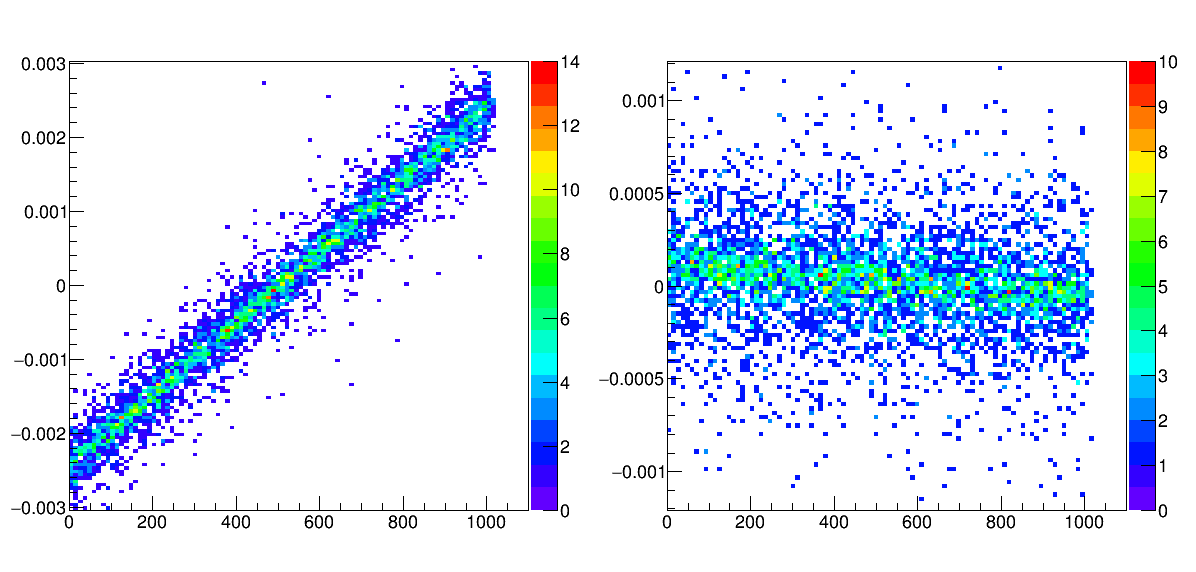

In [49]:
residuals_canvas = TCanvas("residuals_canvas", "residuals_canvas", 1200, 600)
residuals_canvas.Divide(2, 1)
residuals_canvas.cd(1)
phi_residuals_vs_strip[selected_layer].Draw("COLZ")
phi_residuals_vs_strip[selected_layer].GetYaxis().SetRangeUser(-0.003, 0.003)
phi_residuals_vs_strip[selected_layer].SetTitle("")
residuals_canvas.cd(2)
corrected_phi_residuals_vs_strip[selected_layer].Draw("COLZ")
corrected_phi_residuals_vs_strip[selected_layer].GetYaxis().SetRangeUser(-0.0012, 0.0012)
corrected_phi_residuals_vs_strip[selected_layer].SetTitle("")
residuals_canvas

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: cView


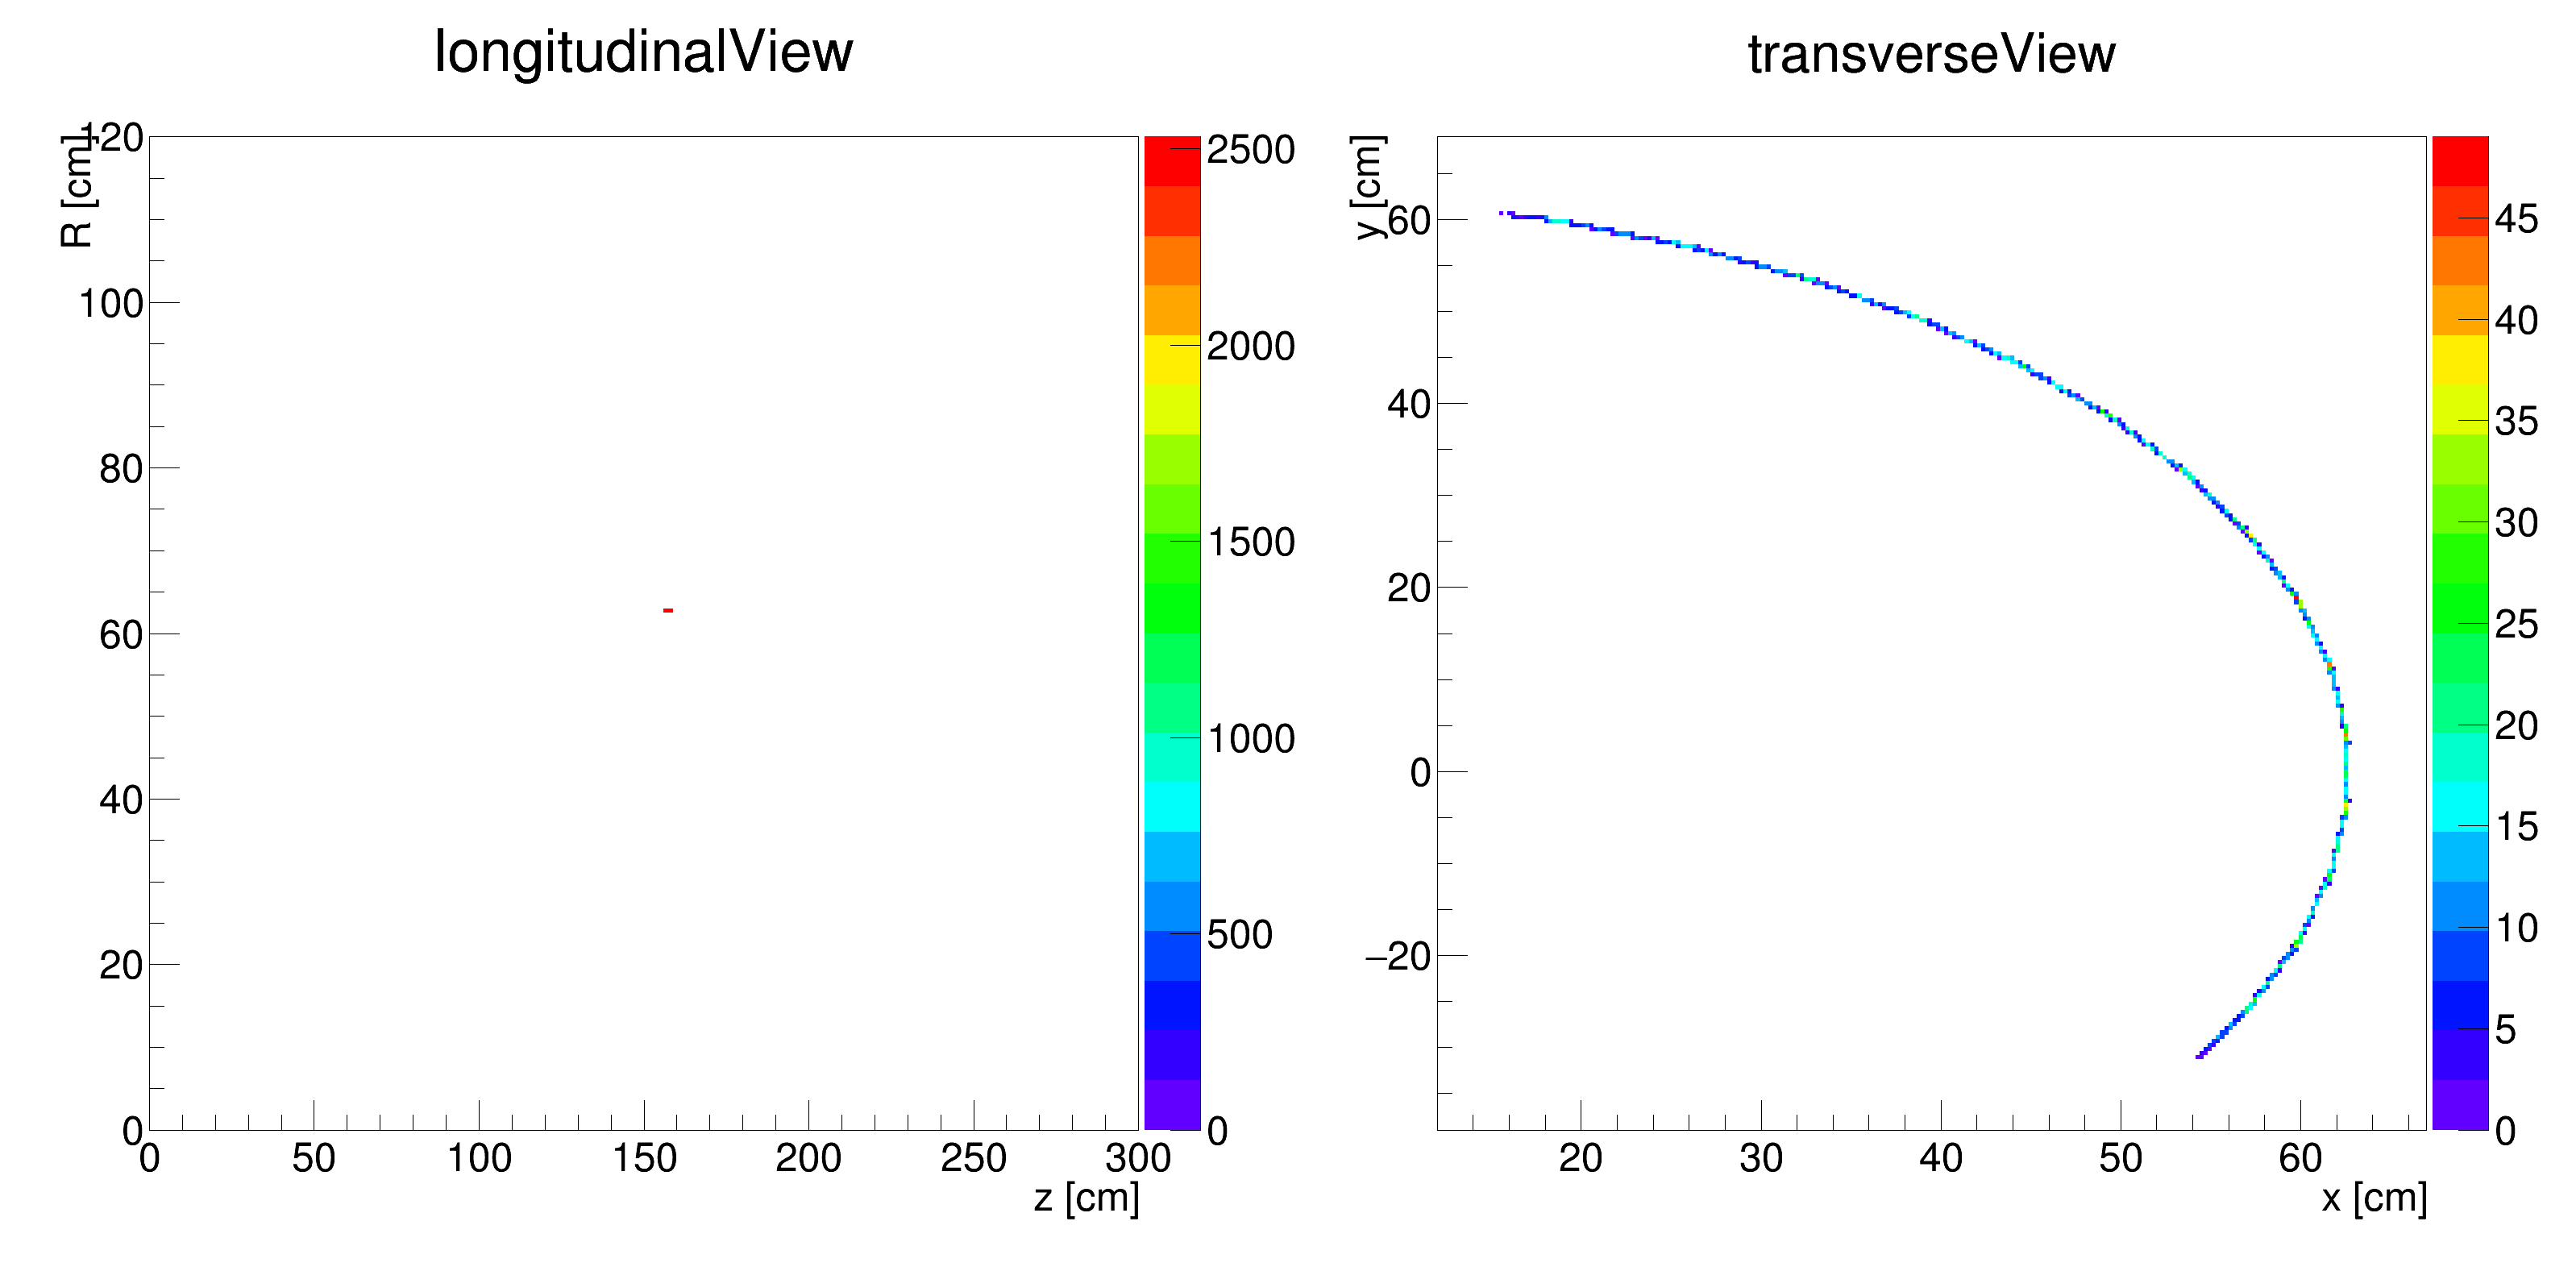

In [50]:
cView = TCanvas("cView", "cView", 3200, 1600)
cView.Divide(2, 1)
cView.cd(1)
longitudinalView.Draw("COLZ")
longitudinalView.GetXaxis().SetTitle("z [cm]")
longitudinalView.GetYaxis().SetTitle("R [cm]")
cView.cd(2)
transverseView.Draw("COLZ")
transverseView.GetXaxis().SetTitle("x [cm]")
transverseView.GetYaxis().SetTitle("y [cm]")
cView

$$\mbox{extrapolated } R = R + \Delta z \tan\theta + \left(\frac{1}{2\rho}\right)^2\cdot\left( - \frac{1}{2} R^2\cdot\Delta z\tan\theta - \frac{1}{2} R\cdot(\Delta z\tan\theta)^2 - \frac{1}{6} (\Delta z\tan\theta)^3 \right)$$

##Extract the strip index from the global phi coordinate of the strip

In [17]:
phiVsStripIndex = TH2D("phiVsStripIndex", "phiVsStripIndex", 200, 0., 0., 200, 0., 0.)
computedStripIndexVsStripIndex = TH2D("computedStripIndexVsStripIndex", "computedStripIndexVsStripIndex",
                                      200, 0., 0., 200, 0., 0.)
# longitudinalView = TH2D("longitudinalView", "longitudinalView", 200, 0, 300, 240, 0, 120)
longitudinalView = TH2D("longitudinalView", "longitudinalView", 200, 0, 0, 240, 0, 0)
transverseView = TH2D("transverseView", "transverseView", 240, 0, 0, 240, 0, 0)

middleR507 = dict()
middleR508 = dict()
diskZ = dict()
RzPairs = dict()


# phi_zero_1 = 0.
# phi_shift_1 = phi_zero_1 + (0.120755416524 + 0.120899256325)/2.
# phi_shift_2 = phi_zero_1 + 0.0982335193492
# A_shift = {132.614: phi_shift_1, 134.194: phi_zero_1,
#            157.415: phi_shift_1, 158.995: phi_zero_1,
#            186.774: phi_shift_1, 188.354: phi_zero_1,
#            221.528: phi_shift_1, 223.108: phi_zero_1,
#            262.67: phi_shift_1, 264.25: phi_zero_1}



# B = {62.5692: 2*math.pi/26, 67.5942: 2*math.pi/26,
#     80.0974: 2*math.pi/32, 85.1224: 2*math.pi/32}


# shift = {62.5692: (0., (0.120755416524 + 0.120899256325)/2.),
#          67.5942: (0., (0.120755416524 + 0.120899256325)/2.),
#          69.564: (0., 1.),
#          74.589: (0., 1.),
#          80.0974: (0., 0.0982335193492),
#          85.1224: (0., 0.0982335193492),
#          86.3283: (0., 1.),
#          91.3533: (0., 1.),
#          96.9668: (0., 1.),
#          101.9918: (0., 1.),
#          102.4625: (0., 1.),
#          107.4875: (0., 1.)}

# firstSecondZ = {128.494: 1,
#                 130.294: 0,
#                 132.614: 1,
#                 134.194: 0,
#                 153.295: 1,
#                 155.095: 0,
#                 157.415: 1,
#                 158.995: 0,
#                 159.215: 0,
#                 182.654: 1,
#                 184.234: 0,
#                 184.454: 0,
#                 186.774: 1,
#                 188.354: 0,
#                 188.574: 0,
#                 217.408: 1,
#                 218.988: 0,
#                 219.208: 0,
#                 221.528: 1,
#                 223.108: 0,
#                 223.328: 0,
#                 258.55: 1,
#                 260.13: 0,
#                 260.35: 0,
#                 262.67: 1,
#                 264.25: 0}

# lookup_R = {int(62.5692*factor): (atan2(d, 62.5692), atan2(d, 62.5692)+0.1208273364, 2*math.pi/26),
#          int(67.5942*factor): (atan2(d, 67.5942), atan2(d, 67.5942)+0.1208273364, 2*math.pi/26),
#          70: (atan2(d, 69.564), atan2(d, 69.564), 2*math.pi/26),
#          75: (atan2(d, 74.589), atan2(d, 74.589), 2*math.pi/26),
#          80: (atan2(d, 80.0974), atan2(d, 80.0974)+0.0982335193492, 2*math.pi/26),
#          85: (atan2(d, 85.1224), atan2(d, 85.1224)+0.0982335193492, 2*math.pi/26),
#          86: (atan2(d, 86.3283), atan2(d, 86.3283)),
#          91: (atan2(d, 91.3533), atan2(d, 91.3533)),
#          97: (atan2(d, 96.9668), atan2(d, 96.9668)),
#          102: (atan2(d, 101.9918), atan2(d, 101.9918)),
#          102: (atan2(d, 102.4625), atan2(d, 102.4625)),
#          107: (atan2(d, 107.4875), atan2(d, 107.4875))}


# For convenience we store the low precision R, the number of modules per ring divided by two
# and the phi shift of the central strip of module 0 for each ring. The same numbers seem to
# apply to all disks.
rns = ((62.5692, 26, 0.1208273364),
       (67.5942, 26, 0.1208273364),
       (69.564, 28, 0.112197348128 ),
       (74.589, 28, 0.112197348128 ),
       (80.0974, 32, 0.0982335193492),
       (85.1224, 32, 0.0982335193492),
       (86.3283, 34, 0.0923480887487),
       (91.3533, 34, 0.0923480887487),
       (96.9668, 38, 0.08267620345175),
       (97, 38, 0.08267620345175),
       (101.9918, 38, 0.08267620345175),
       (102.1, 38, 0.08267620345175),
       (102.4625, 40, 0.078537338426),
       (102.5, 40, 0.078537338426),
       (107.4875, 40, 0.078537338426),
       (107.5, 40, 0.078537338426))

# Half length of the module perpendicular to the strip direction = strip_pitch*number_of_strips/2
# We use number_of_strips/2+1 as it works better with the floors, roundings and precision.
d = 0.009*508
# Multiplicative factor used to scale the R of the stub before flooring it. It allows to gain
# enough precision to distinguish all rings.
factor = 4

# Lookup table providing all the numbers necessary to perform the radial strip corrections in the 2S
# modules of the disks. It also includes the 1/R^2, event though it is not used in this correction.
# This number is used for the extrapolation of R we store it here for convenience.
# The limited precision value of int(R*4) is sufficient to distinguish all the R values. Two values
# are provided and they are valid for different z. The lookup_z map allows to select the appropriate
# value.The shift is roughly 2pi/N, however we prefer to use the phi of the central strip in module 0.
lookup_R = {}
for a in rns:
    R = a[0]
    N = a[1]
    shift = a[2]
    lookup_R[int(R*factor)] = (atan2(d, R), atan2(d, R)+shift, 2*math.pi/N, 1./(R**2))

# Look-up table to determine the shift to take for the given z
lookup_z = {128: 1,
            130: 0,
            132: 1,
            134: 0,
            153: 1,
            155: 0,
            157: 1,
            158: 0,
            159: 0,
            182: 1,
            184: 0,
            186: 1,
            188: 0,
            217: 1,
            218: 0,
            219: 0,
            221: 1,
            223: 0,
            258: 1,
            260: 0,
            262: 1,
            264: 0}




i=0
max_events = 100000
# max_events = tree.GetEntries()
p = ProgressBar(max_events)
for event in tree:
    if i>=max_events:
        break
    i+=1
    if i%(max_events/100) == 0:
        p.animate(i)
    if len(event.L1TkSTUB_x) != len(event.L1TkSTUB_y) or len(event.L1TkSTUB_y) != len(event.L1TkSTUB_z):
        print "ERROR: INCONSISTENT NUMBER OF STUB COORDINATES"
        break
    
    for pdgId, layer, x, y, z, module, strip, in itertools.izip(event.L1TkSTUB_pdgID,
                                                                event.L1TkSTUB_layer,
                                                                event.L1TkSTUB_x,
                                                                event.L1TkSTUB_y,
                                                                event.L1TkSTUB_z,
                                                                event.L1TkSTUB_module,
                                                                event.L1TkSTUB_strip):
        if abs(pdgId) != 13:
            continue
        if layer < 11:
            continue
            
        R = sqrt(x**2+y**2)
        if R < 60.:
            continue
#         if R < 60. or R > 65.:
#             continue
#         if R < 60. or R > 68.:
#             continue
#         if R < 70. or R > 76.:
#             continue
#         if R < 78. or R > 81.:
#             continue
#         if R < 80. or R > 86.:
#             continue
#         if R < 86. or R > 92.:
#             continue
#         if R < 96. or R > 102.:
#             continue
#         if R < 102.:
#             continue
#         if R < 105.:
#             continue
#         if module < 56:
#             continue
            
#         print module
    
#         if R < 68. or R > 75.:
#             continue
#         if R < 75.:
#             continue
#         if R < 61.:
#             continue
        
#         if module != 49 and module != 48 and module != 47:
#             continue
#         if module != 0:
#             continue

        # There is an even number of strips in each 2S module = 1016 (x2 because there are two 5 cm strips).
        # The strip index starts from 0 so the middle strips are 507, 508. The middle value is taken to be 507.5.

        phi = atan2(y, x)

        # B = 2*math.pi/32.
        # B = 2*math.pi/26.

        # We use 508 instead of 507.5 because it avoids a mismatch in the last strips (likely due
        # to numerical inaccuracies).
        # d = 0.009*508
        # alpha = atan2(d, R)
        # print "B =", B
        # print "alpha =", alpha
        # computed_strip_index = ((phi+math.pi)%B)*512./alpha
        # computed_strip_index = int(phi*R/0.009)+512
        # print
        # print "phi =", phi
        # print "phi%B =", ((phi+alpha)%B)-alpha
        # if (strip == 507 or strip == 508) and module == 0 and R < 65.:
        # if strip > 1010 and module == 0 and R < 65.:
        #     print strip, phi
        
        # if z > 140:
        #     continue

        
        # if module != 0:
        #     continue
        
#         shortR = round(R*10000)/10000.
#         # shortZ = round(z*10000)/10000.
#         shortZ = round(z)

#         if strip == 507:
# #             if module == 0:
# #                 print "507: ", phi
#             middleR507[shortR] = z
#             diskZ[z] = shortR
#             RzPairs[(shortR, shortZ)] = layer
#         elif strip == 508:
# #             if module == 0:
# #                 print "508: ", phi
#             middleR508[shortR] = z
        
        # A = alpha
        # A = alpha + A_shift[shortZ]
        strip_index_lookup = lookup_R[int(R*factor)]
        A = strip_index_lookup[lookup_z[int(z)]]
        B = strip_index_lookup[2]
        # if module%2 == 0:
            # The number used for the shift is the phi of the
            # center of module 0 (average of the phi of the two central strips).
            
            # A = A + (0.120755416524 + 0.120899256325)/2.
            # A = A + 0.0982335193492
            # print "int(z) =", int(z)
        
#         print
#         print "A =", A
#         print "AA =", shift[int(R)], firstSecondZ[int(z)], int(z)
#         print

        computed_strip_index = int(((phi+A)%B)*R/0.009)
        # if strip != computed_strip_index and module == 0 and R < 65.:
        #     print "computed strip index =", strip, computed_strip_index
        
        phiVsStripIndex.Fill(phi, strip)
        computedStripIndexVsStripIndex.Fill(computed_strip_index, strip)
        
        longitudinalView.Fill(z, R)
        transverseView.Fill(x, y)


 [**********************99%***********************]  99000 of 100000 complete

TFile::Append:0: RuntimeWarning: Replacing existing TH1: phiVsStripIndex (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: computedStripIndexVsStripIndex (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: longitudinalView (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: transverseView (Potential memory leak).


In [18]:
print "R and z for strip 507"
print
for R in middleR507:
    print R, middleR507[R]

print
print
print "R and z for strip 508"
print
for R in middleR508:
    print R, middleR508[R]
    
print
print
print "z and R for strip 507"
print
for z in diskZ:
    print z, diskZ[z]
    
    
print
print
print
print "unique pairs of R and z for all disks"
for Rz in sorted(RzPairs):
    print RzPairs[Rz], Rz

R and z for strip 507



R and z for strip 508



z and R for strip 507




unique pairs of R and z for all disks


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


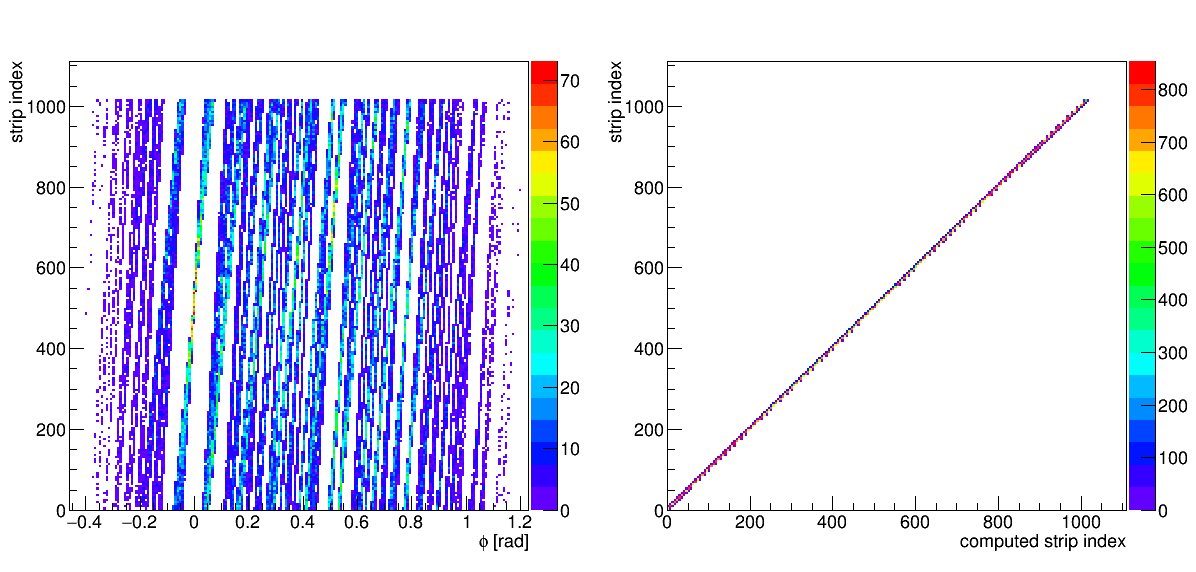

In [19]:
c = TCanvas("c", "c", 1200, 600)
c.Divide(2,1)
c.cd(1)
phiVsStripIndex.Draw("COLZ")
phiVsStripIndex.SetTitle("")
phiVsStripIndex.GetXaxis().SetTitle("#phi [rad]")
phiVsStripIndex.GetYaxis().SetTitle("strip index")
phiVsStripIndex.GetYaxis().SetTitleOffset(1.6)
c.cd(2)
computedStripIndexVsStripIndex.SetTitle("")
computedStripIndexVsStripIndex.Draw("COLZ")
computedStripIndexVsStripIndex.GetXaxis().SetTitle("computed strip index")
computedStripIndexVsStripIndex.GetYaxis().SetTitle("strip index")
computedStripIndexVsStripIndex.GetYaxis().SetTitleOffset(1.6)
c

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: cView


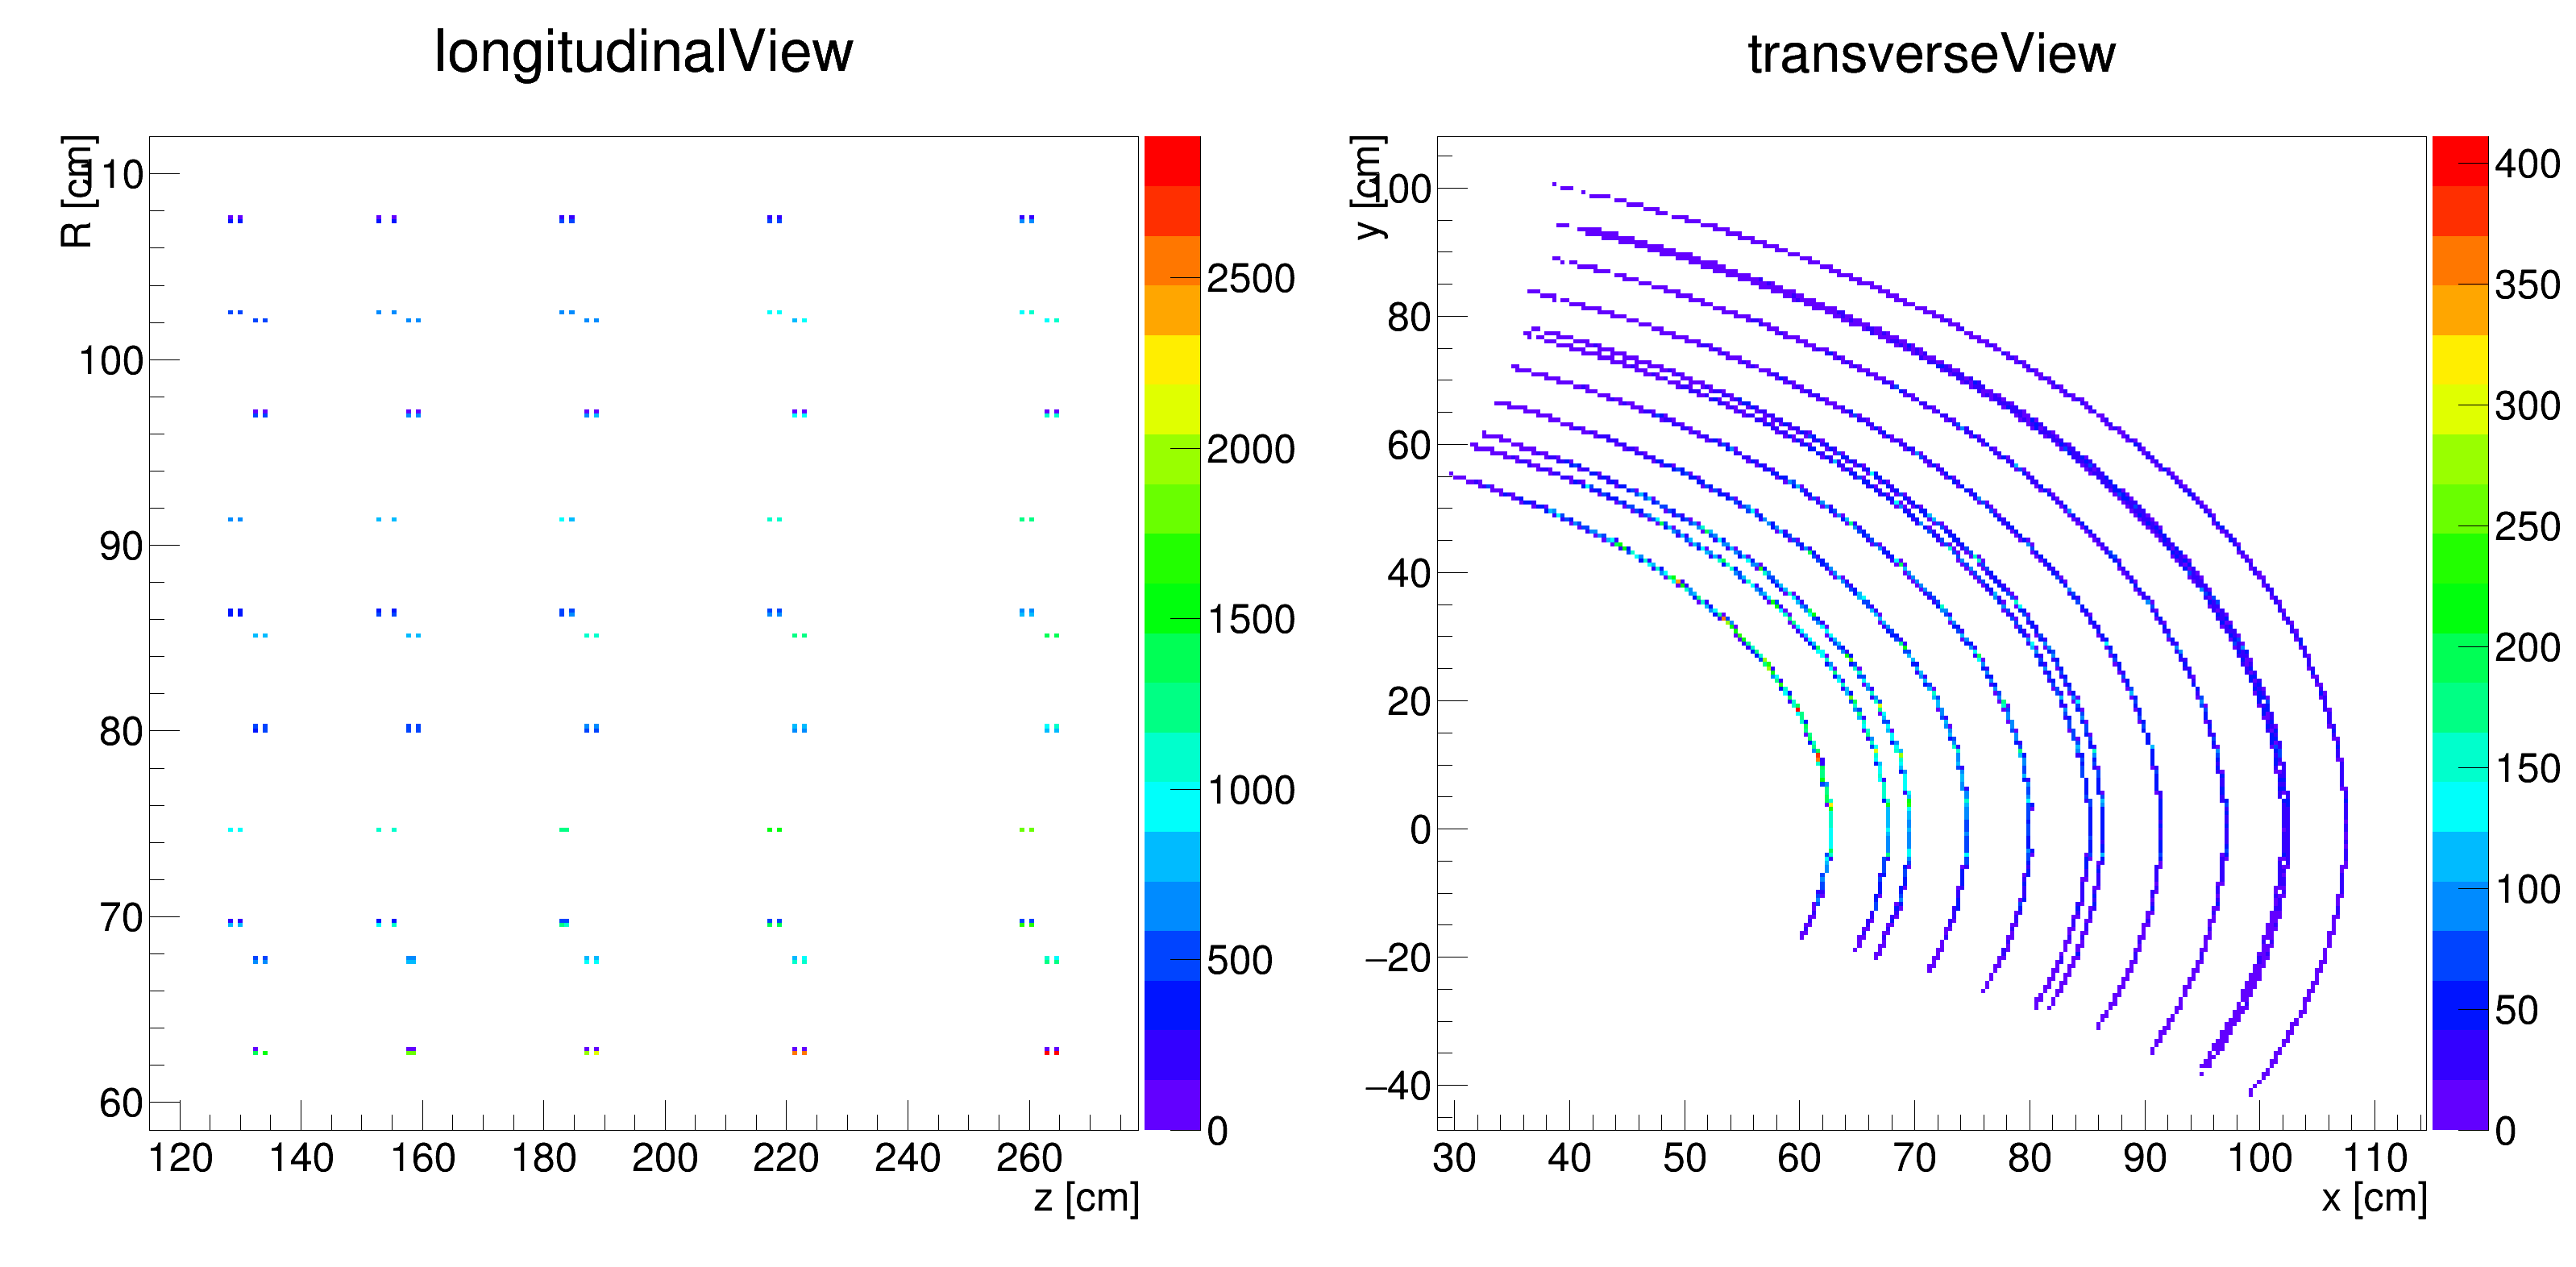

In [20]:
cView = TCanvas("cView", "cView", 3200, 1600)
cView.Divide(2, 1)
cView.cd(1)
longitudinalView.Draw("COLZ")
longitudinalView.GetXaxis().SetTitle("z [cm]")
longitudinalView.GetYaxis().SetTitle("R [cm]")
cView.cd(2)
transverseView.Draw("COLZ")
transverseView.GetXaxis().SetTitle("x [cm]")
transverseView.GetYaxis().SetTitle("y [cm]")
cView

There are 52 modules at the innermost two radii of disk 11 (and this should apply at the same radius for all the disks)

In [135]:
R1 = 62.5691991768
R2 = 62.5691982884
print int(R1*100000)/100000.
print int(R2*100000)/100000.

print

print round(R1*100000)/100000.
print round(R2*100000)/100000.

62.56919
62.56919

62.5692
62.5692


In [14]:
print int(62.5692*4)
print 101.9918*4, int(101.9918*4)
print 102.4625*4, int(102.4625*4)

250
407.9672 407
409.85 409


In [21]:
(0.0827214686686 + 0.0826309382349)/2.

0.08267620345175

In [48]:
(0.0784954678389 + 0.0785792090131)/2.

0.078537338426

In [3]:
(0.112257679276 + 0.11213701698)/2.

0.112197348128